First Import all the libraries

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense

Then we load the MNIST dataset and split it into training and test sets.

In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Next, reshape the data and normalize the images by dividing it by the number of pixels in this case 255. Also, noisy data is created.

In [3]:
# Split the dataset into a training set and a test set
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_noisy = x_train + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Next, we will create a deep denoising autoencoder. This autoencoder consists out of multiple convolutional, maxpooling and upsampling layers. The upsampling layer is used to increase the spatial resolution of the input feature map by performing a form of interpolation

In [4]:
# Train a deep denoising autoencoder on the full training set
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Here the model is trained.

In [6]:
train_new = False
if train_new:

    autoencoder.fit(x_train_noisy, x_train, epochs=5, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))
    # Save the model weights as an HDF5 file
    autoencoder.save_weights('trained_autoenconder_1.h5')
else:
    # Load the model weights
    autoencoder.load_weights('trained_autoenconder_1.h5')

Epoch 1/5
469/469 [==============================] - 48s 101ms/step - loss: 0.1568 - val_loss: 0.1140
Epoch 2/5
469/469 [==============================] - 45s 96ms/step - loss: 0.1113 - val_loss: 0.1066
Epoch 3/5
469/469 [==============================] - 45s 96ms/step - loss: 0.1064 - val_loss: 0.1045
Epoch 4/5
469/469 [==============================] - 46s 98ms/step - loss: 0.1041 - val_loss: 0.1021
Epoch 5/5
469/469 [==============================] - 45s 96ms/step - loss: 0.1026 - val_loss: 0.1010


Here the trained network is used to decode the noisy data that was created before. As can be seen in the results below, the noisy data images look very noisy. The autoencoder trained before is then used to decode this noisy data. The autoencoder takes the noisy data as input and saves the output in decoded_imgs. As can be seen in the second row. This images are far more readable than the noisy ones. 

313/313 [==============================] - 1s 4ms/step


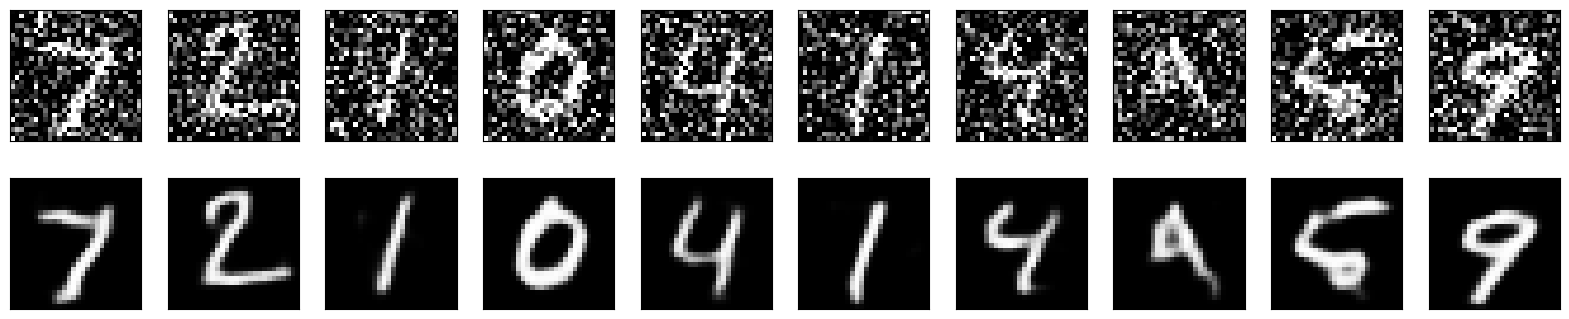

In [7]:
# Check that the images are fairly well reconstructed
decoded_imgs = autoencoder.predict(x_test_noisy)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
# Extract the encoder portion of the autoencoder to reuse its lower layers
encoder = Model(input_img, encoded)

313/313 [==============================] - 1s 2ms/step
(10000, 7, 7, 32)


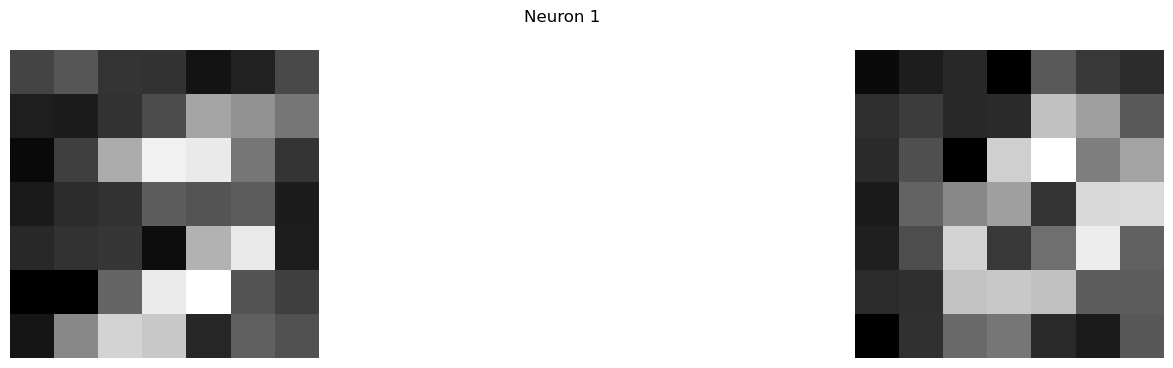

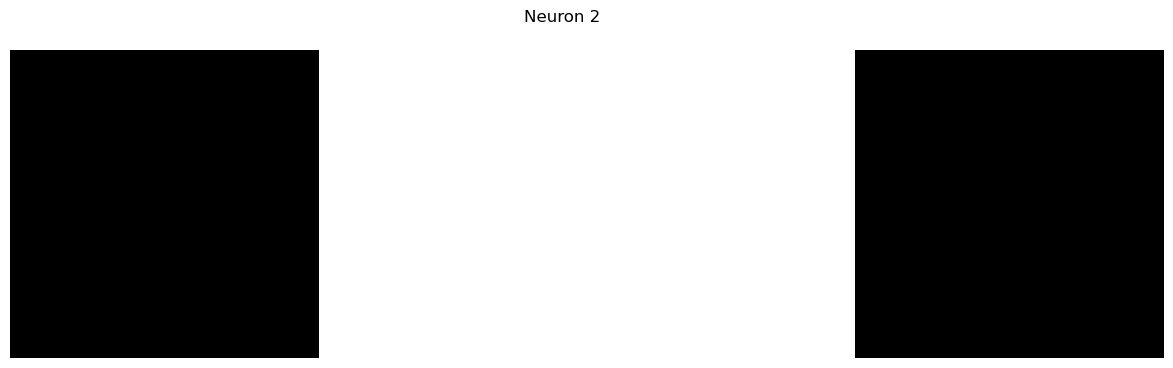

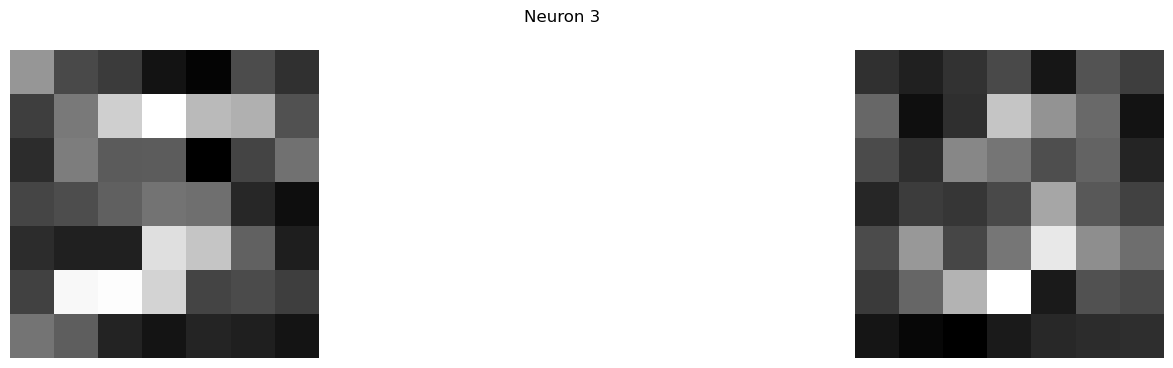

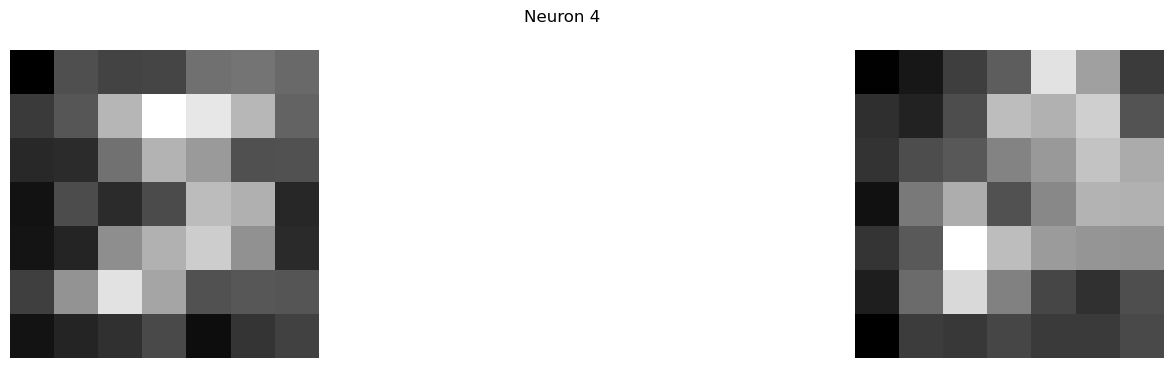

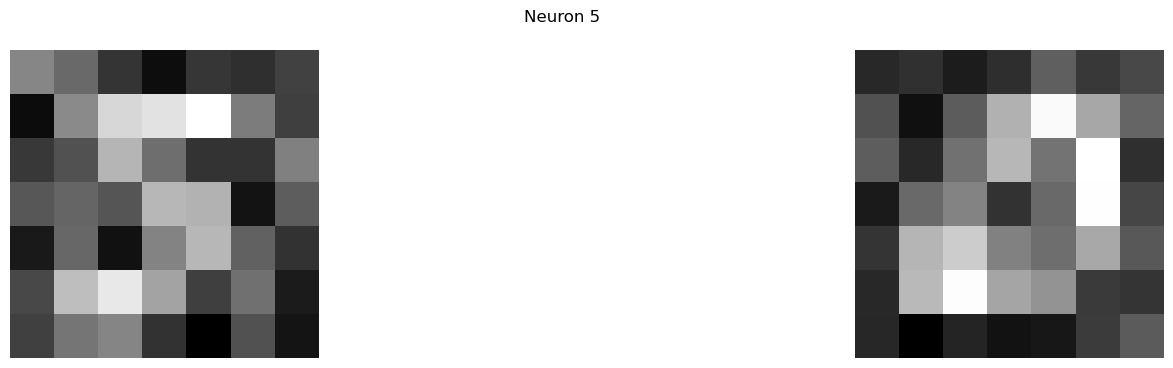

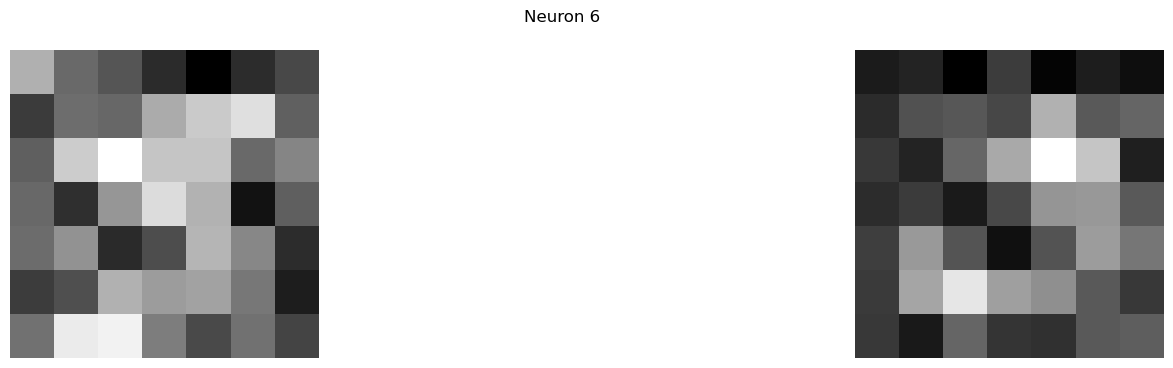

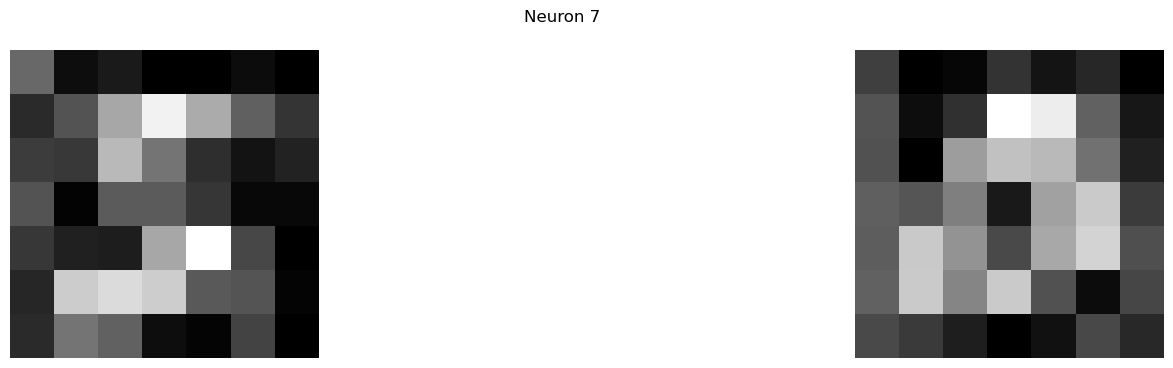

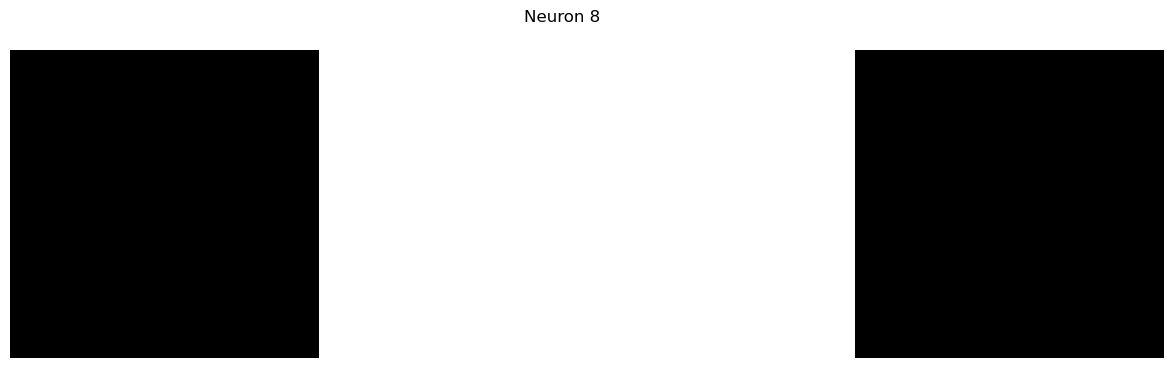

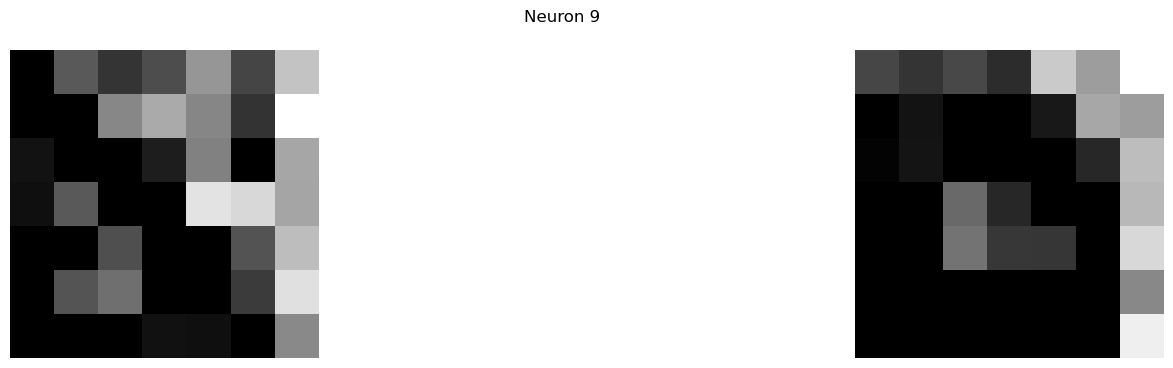

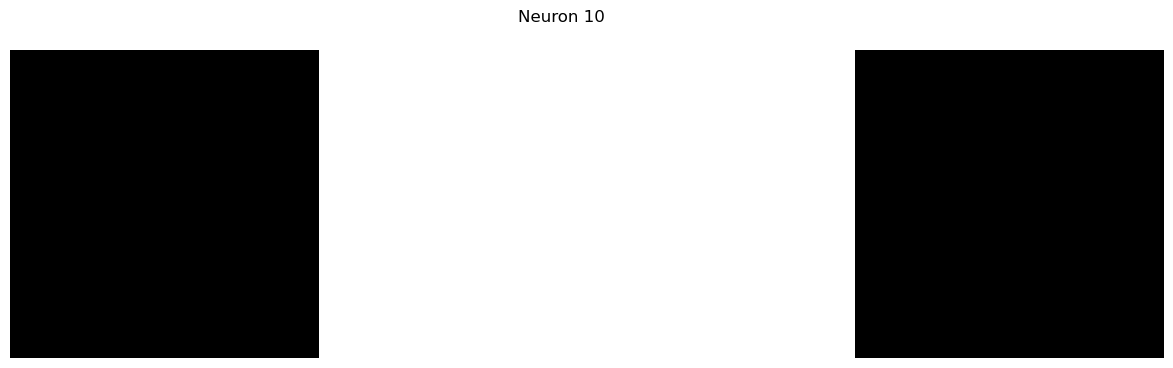

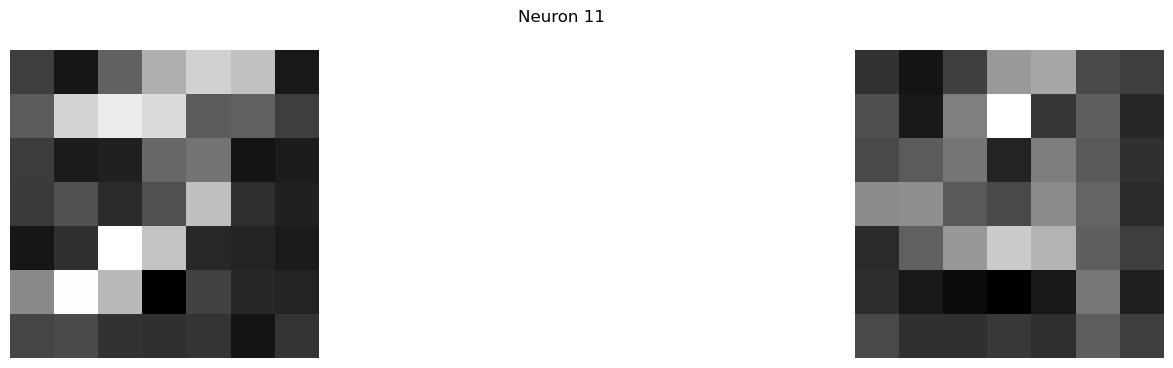

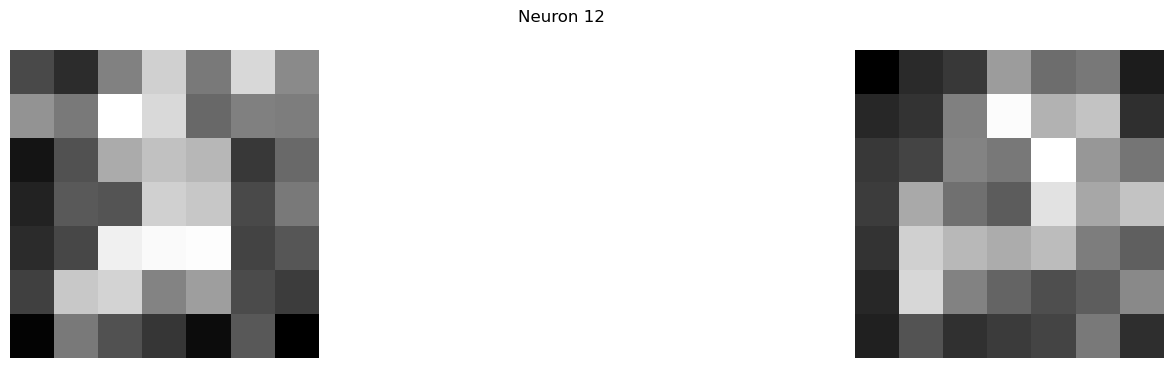

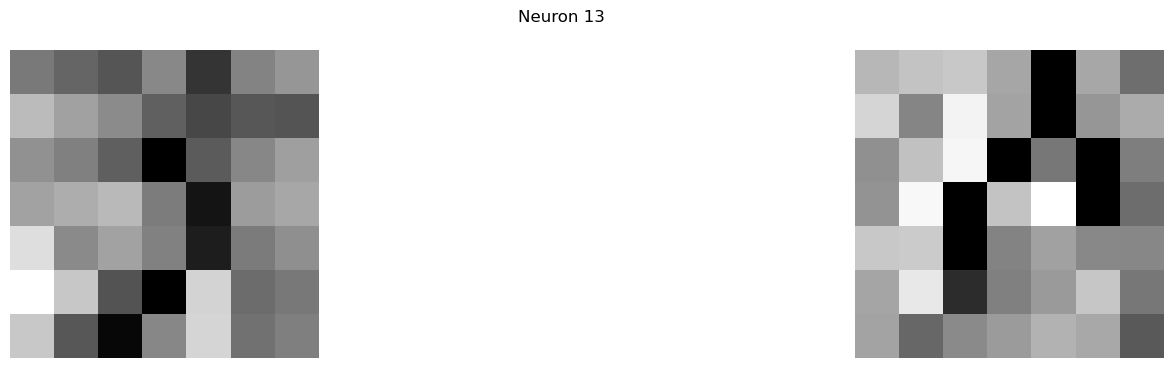

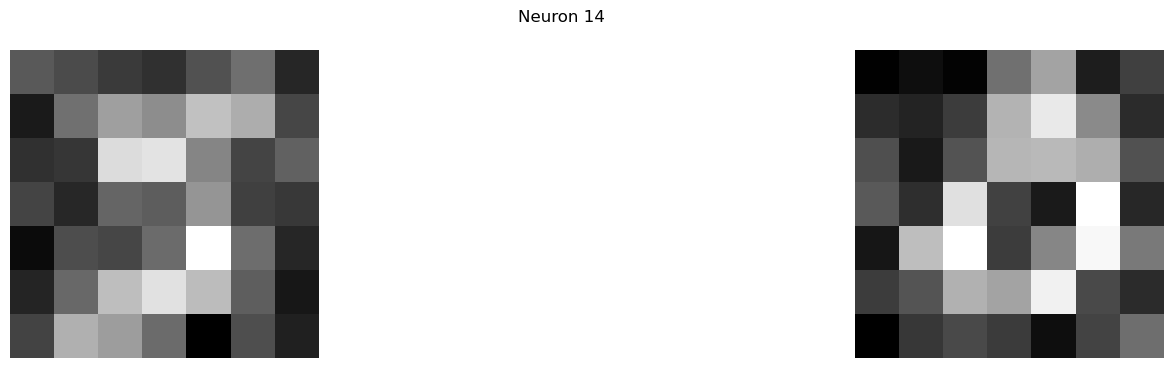

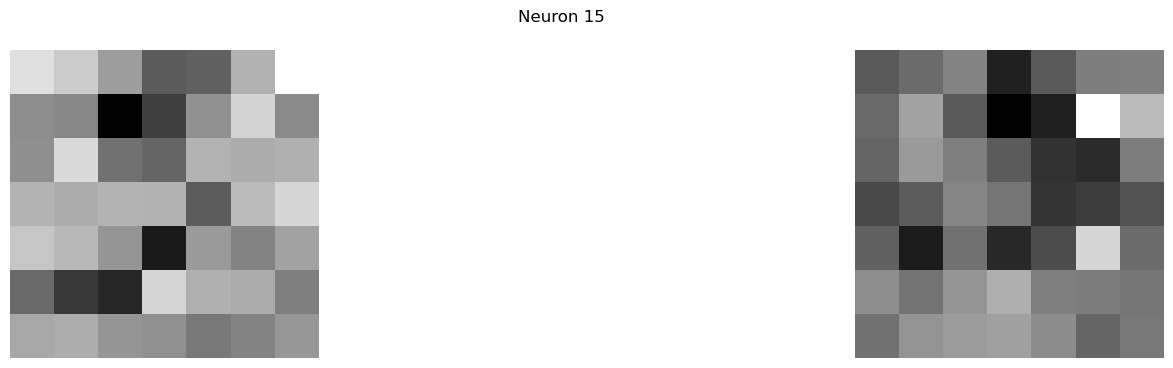

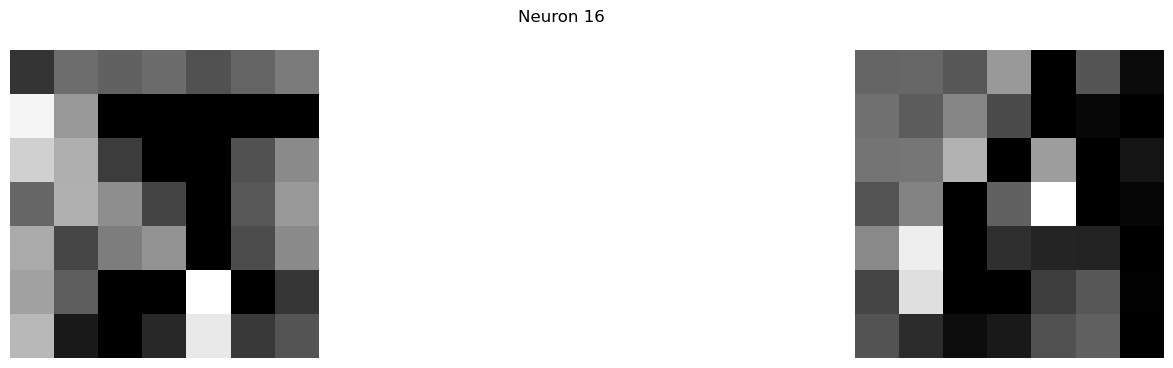

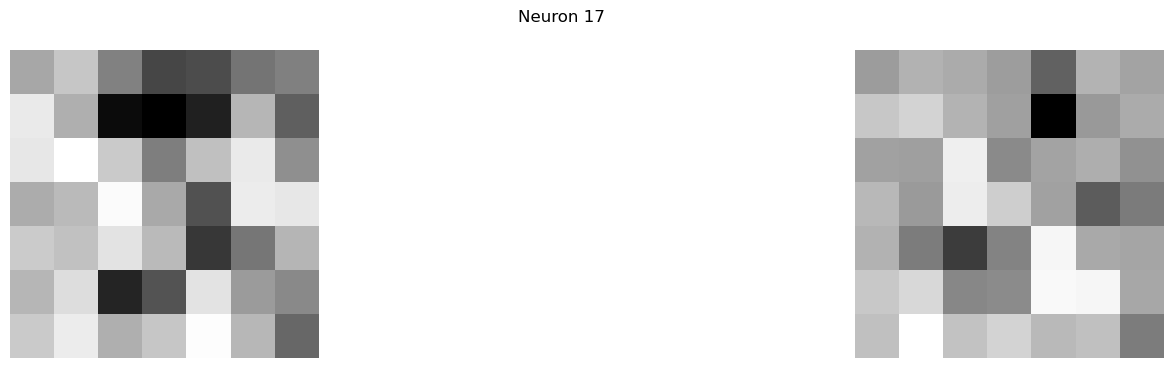

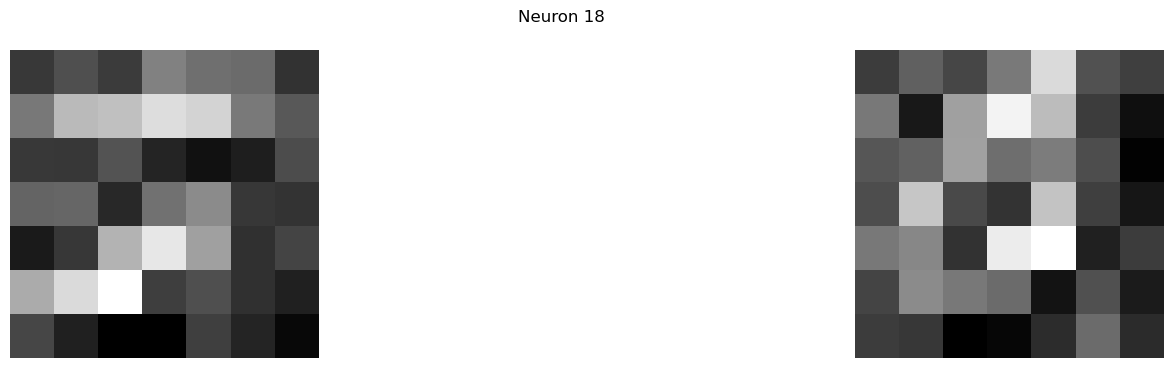

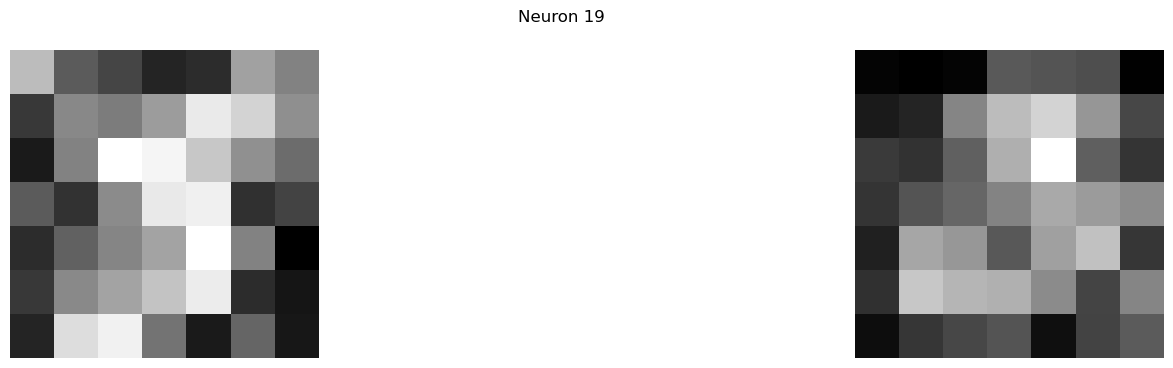

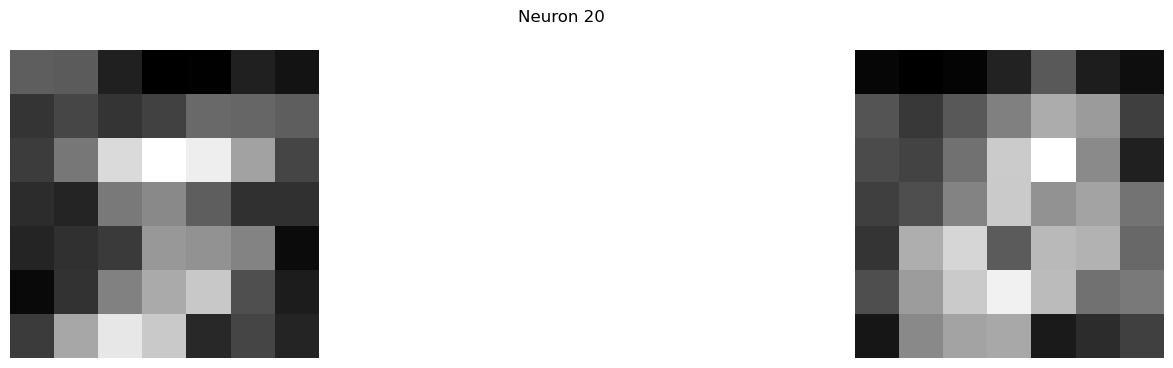

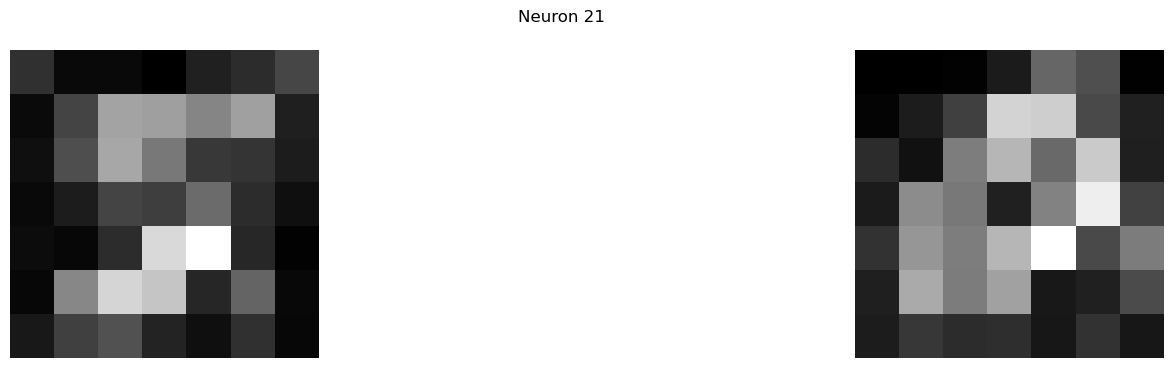

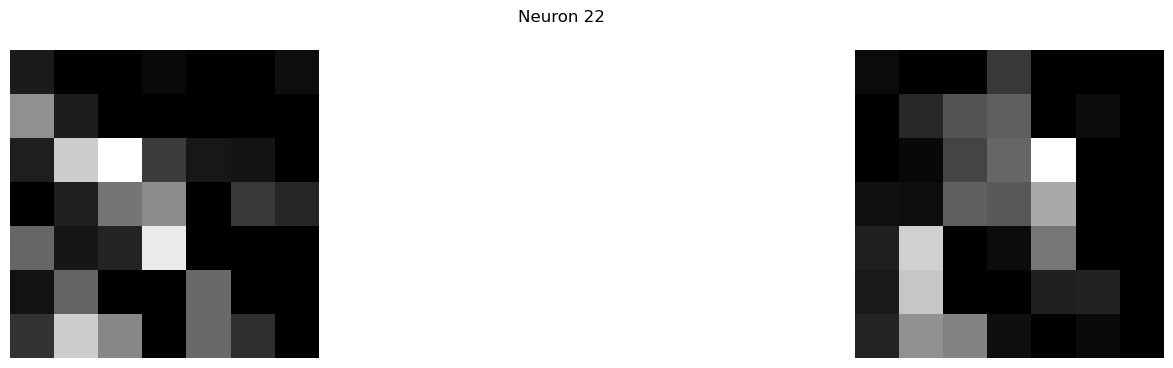

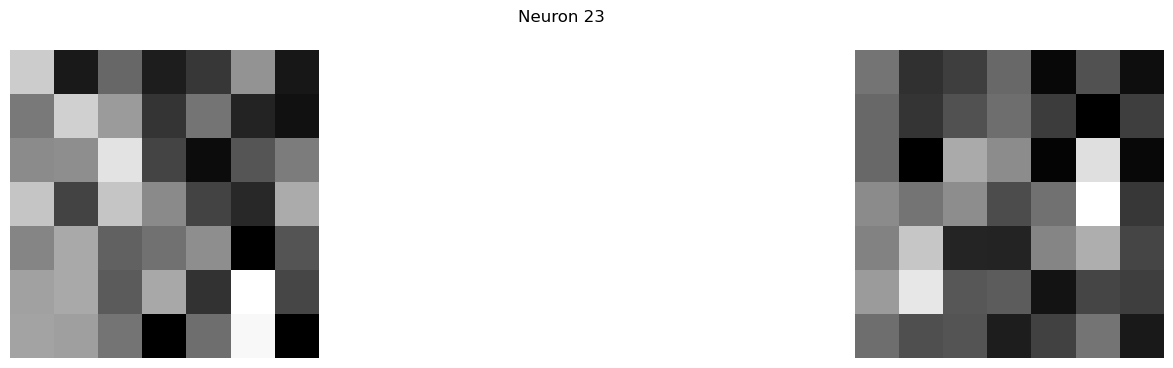

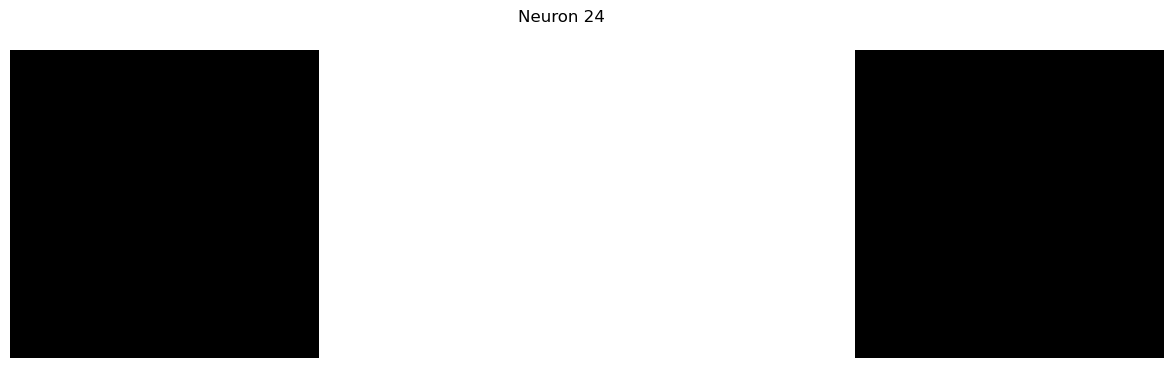

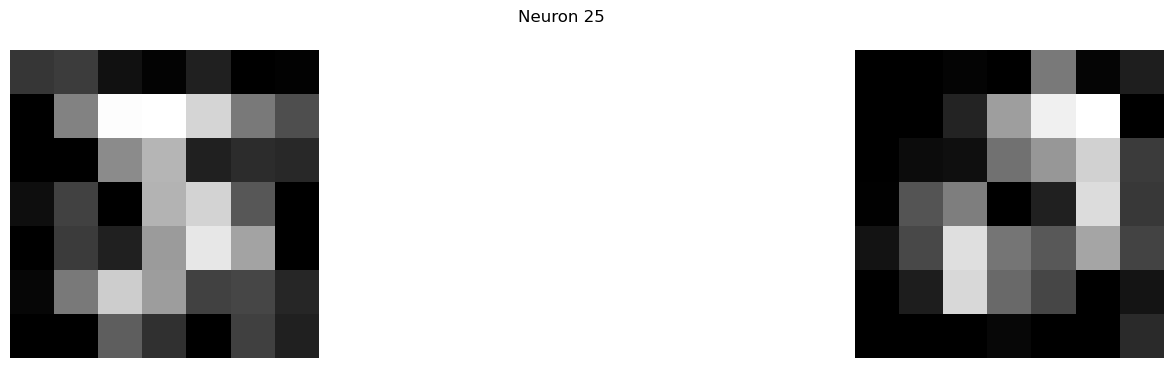

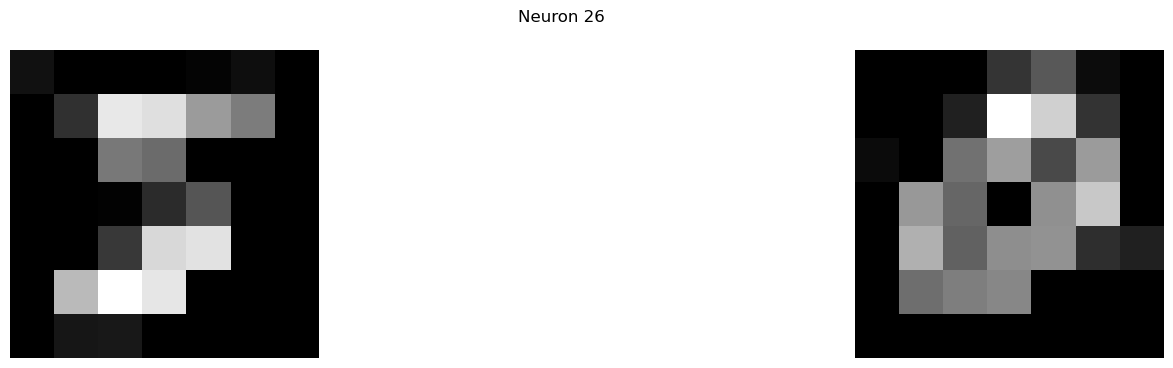

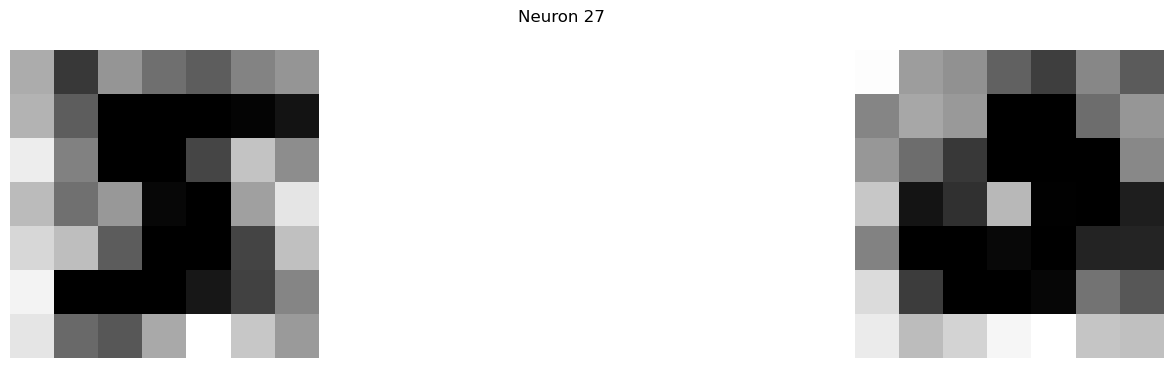

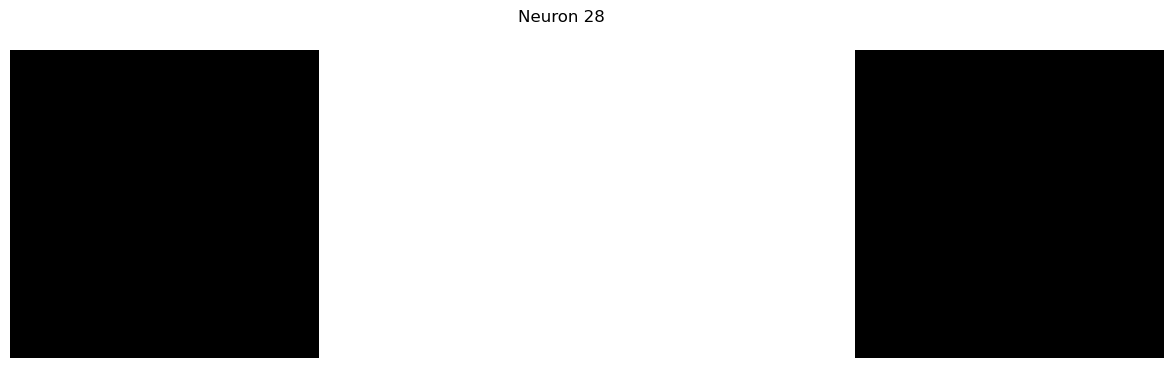

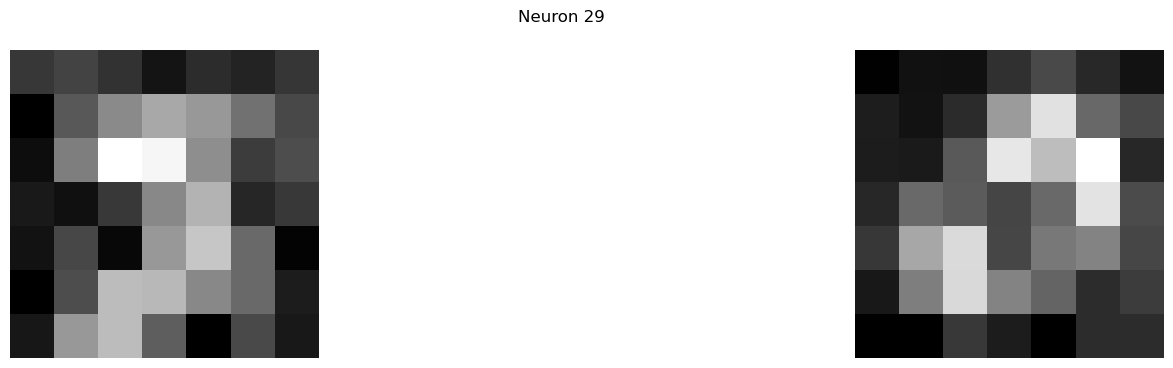

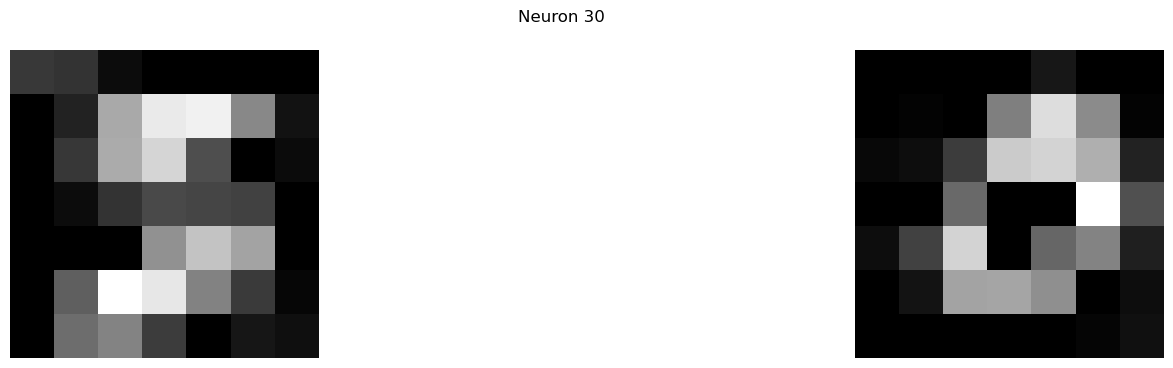

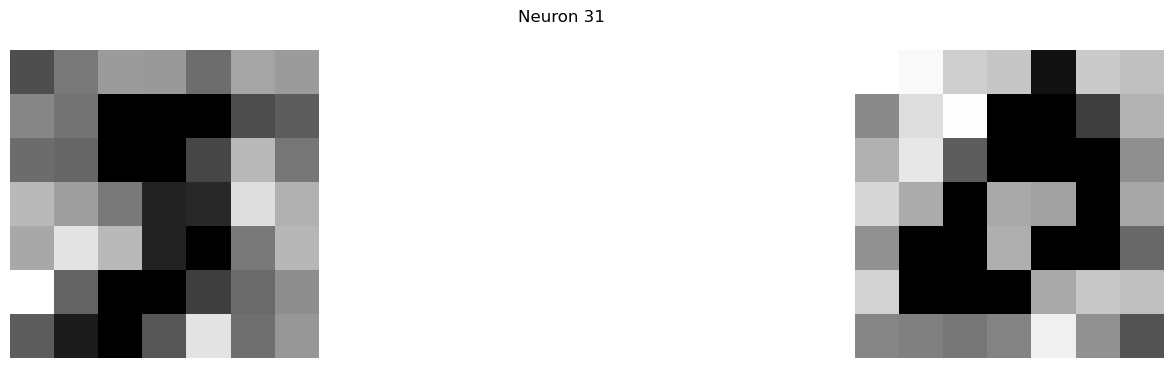

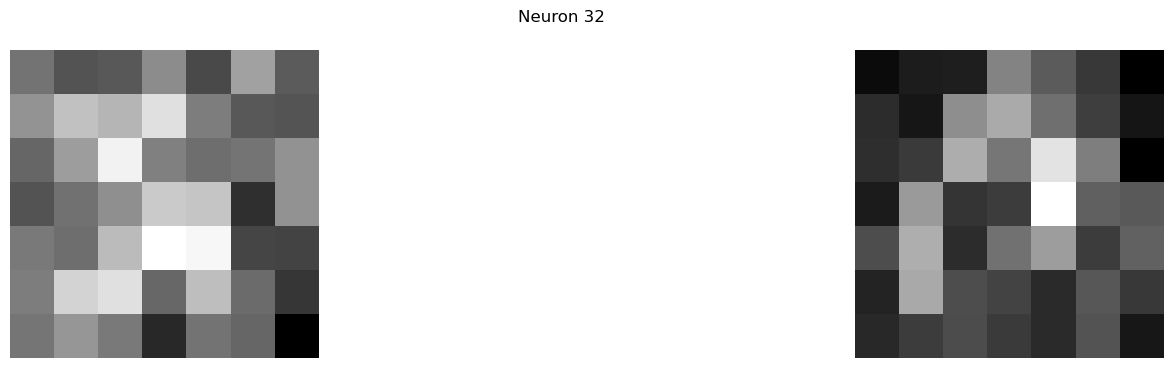

In [9]:
# Visualize the images that most activate each neuron in the coding layer
import numpy as np
import matplotlib.pyplot as plt
encoded_imgs = encoder.predict(x_train_noisy[:10000])
print(encoded_imgs.shape)
n = 2  # Number of images to visualize for each neuron
for i in range(encoded_imgs.shape[-1]):
    fig, ax = plt.subplots(1, n, figsize=(20, 4))
    for j in range(n):
        img = encoded_imgs[:, :, :, i][j]
        ax[j].imshow(img.reshape(7, 7), cmap='gray')
        ax[j].axis('off')
    plt.suptitle(f'Neuron {i+1}')
    plt.show()

Here the images are visualized to see the image that actiates each neuron the most. 

313/313 [==============================] - 1s 2ms/step


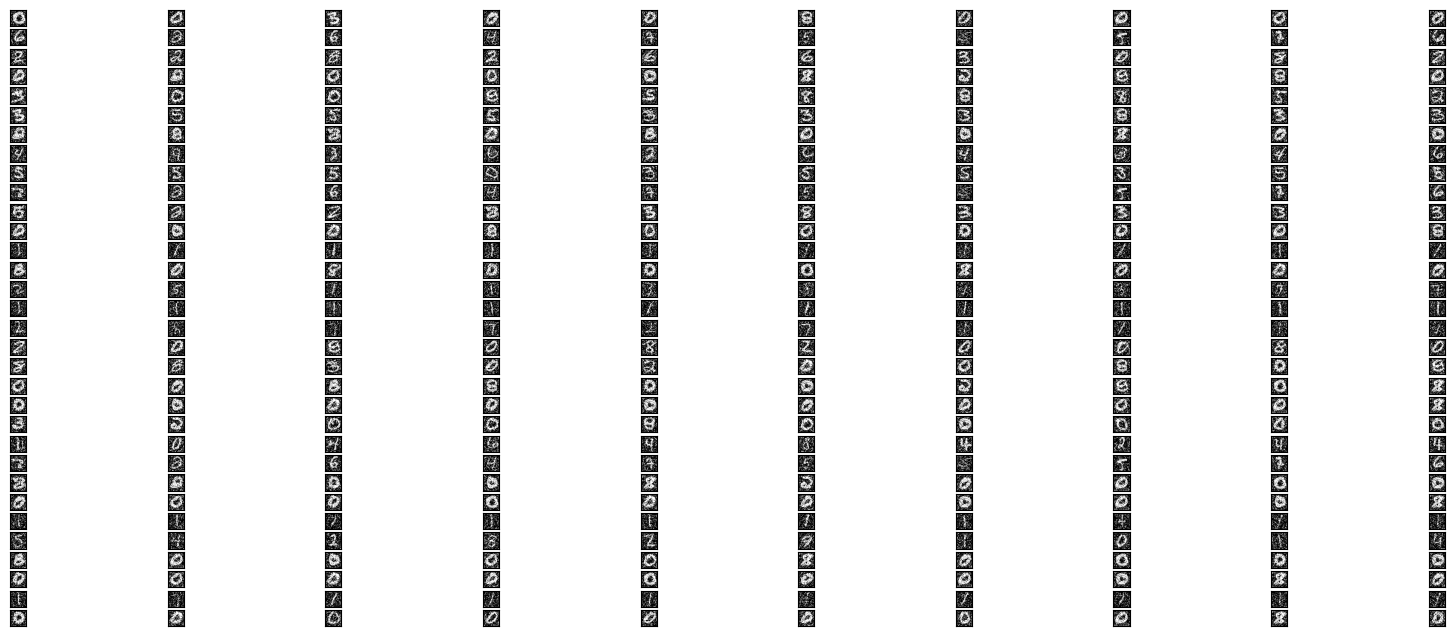

In [16]:
# Visualize the images that most activate each neuron in the coding layer
layer_name = 'max_pooling2d_1'
intermediate_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(str(autoencoder.layers[4].name)).output)
                                                       
# Get the activations for the test set
intermediate_output = intermediate_layer_model.predict(x_test_noisy)

# Find the images that most activate each neuron in the coding layer
n_neurons = intermediate_output.shape[-1]
n_images = 10
indices = np.zeros((n_images, n_neurons))
for i in range(n_neurons):
    indices[:, i] = np.argsort(intermediate_output[:, :, :, i].mean(axis=(1, 2)))[-n_images:]

# Display the images that most activate each neuron in the coding layer
plt.figure(figsize=(20, 8))
for i in range(n_neurons):
    for j in range(n_images):
        ax = plt.subplot(n_neurons, n_images, i * n_images + j + 1)
        plt.imshow(x_test_noisy[int(indices[j, i])].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

Now we build a DNN classification model reusing the layers of the autoencoder. Notice that only the lower layers are used. This network is trained with 500 images from the training set. The lowest four layers are then frozen to see if the model performs better or worese with or without pretraining. 

In [17]:
# Build a classification DNN, reusing the lower layers of the autoencoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(10, activation='softmax')(x)
classifier = Model(input_img, x)

In [18]:
# Freeze the weights of the lower layers of the classifier
for layer in classifier.layers[:4]:
    layer.trainable = False

In [19]:
# Train the classifier using only 500 images from the training set
x_train_small = x_train[:500]
y_train_small = y_train[:500]
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.fit(x_train_small, y_train_small, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
16/16 [==============================] - 6s 378ms/step - loss: 2.1528 - accuracy: 0.4620 - val_loss: 1.9834 - val_accuracy: 0.6503
Epoch 2/20
16/16 [==============================] - 5s 314ms/step - loss: 1.7505 - accuracy: 0.7700 - val_loss: 1.6389 - val_accuracy: 0.6819
Epoch 3/20
16/16 [==============================] - 4s 255ms/step - loss: 1.3699 - accuracy: 0.7560 - val_loss: 1.3335 - val_accuracy: 0.7362
Epoch 4/20
16/16 [==============================] - 5s 360ms/step - loss: 1.0482 - accuracy: 0.8460 - val_loss: 1.1022 - val_accuracy: 0.7617
Epoch 5/20
16/16 [==============================] - 5s 347ms/step - loss: 0.8277 - accuracy: 0.8520 - val_loss: 0.9424 - val_accuracy: 0.7792
Epoch 6/20
16/16 [==============================] - 5s 342ms/step - loss: 0.6795 - accuracy: 0.8700 - val_loss: 0.8284 - val_accuracy: 0.7943
Epoch 7/20
16/16 [==============================] - 5s 312ms/step - loss: 0.5801 - accuracy: 0.8740 - val_loss: 0.7552 - val_accuracy: 0.8079
Epoch 

In [20]:
# Evaluate the classifier performance with and without pretraining
score = classifier.evaluate(x_test, y_test, verbose=0)
print("Test accuracy without pretraining:", score[1])

Test accuracy without pretraining: 0.879800021648407


In [21]:
# Build a classification DNN, reusing the lower layers of the autoencoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(10, activation='softmax')(x)
classifier = Model(input_img, x)

In [22]:
# Unfreeze the weights of the lower layers of the classifier
for layer in classifier.layers[:4]:
    layer.trainable = True

In [23]:
# Take the pretrained layers
classifier.layers[0].set_weights(autoencoder.layers[0].get_weights())
classifier.layers[1].set_weights(autoencoder.layers[1].get_weights())
classifier.layers[2].set_weights(autoencoder.layers[2].get_weights())
classifier.layers[3].set_weights(autoencoder.layers[3].get_weights())
classifier.layers[4].set_weights(autoencoder.layers[4].get_weights())
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.fit(x_train_small, y_train_small, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
16/16 [==============================] - 6s 376ms/step - loss: 1.5904 - accuracy: 0.5120 - val_loss: 0.8916 - val_accuracy: 0.7381
Epoch 2/20
16/16 [==============================] - 6s 382ms/step - loss: 0.5810 - accuracy: 0.8380 - val_loss: 0.8192 - val_accuracy: 0.7516
Epoch 3/20
16/16 [==============================] - 6s 381ms/step - loss: 0.3858 - accuracy: 0.8700 - val_loss: 0.6449 - val_accuracy: 0.7842
Epoch 4/20
16/16 [==============================] - 6s 389ms/step - loss: 0.2987 - accuracy: 0.9080 - val_loss: 0.5031 - val_accuracy: 0.8413
Epoch 5/20
16/16 [==============================] - 6s 423ms/step - loss: 0.2192 - accuracy: 0.9380 - val_loss: 0.4076 - val_accuracy: 0.8701
Epoch 6/20
16/16 [==============================] - 6s 405ms/step - loss: 0.1611 - accuracy: 0.9540 - val_loss: 0.4306 - val_accuracy: 0.8603
Epoch 7/20
16/16 [==============================] - 6s 390ms/step - loss: 0.1247 - accuracy: 0.9620 - val_loss: 0.4090 - val_accuracy: 0.8723
Epoch 

In [24]:
score = classifier.evaluate(x_test, y_test, verbose=0)
print("Test accuracy with pretraining:", score[1])

Test accuracy with pretraining: 0.9038000106811523


If we compare the pretrained model with the not pretrained model we can see that the pretrained model performs better than the not pretrained model. The not pretrained model has an accuracy of around 88 procent where the pretrained model has an accuracy of 90%. 